In [14]:
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import csv


class Task:
    def __init__(self, n=None):
        if n == None:
            n = 100
        self.n = np.random.randint(n, 2 * n)
        self.W = np.random.randint(10 * n, 20 * n)
        self.S = np.random.randint(10 * n, 20 * n)
        while True:
            self.w = np.round(np.random.random(self.n) * 10 * self.W / self.n, 5)
            self.s = np.round(np.random.random(self.n) * 10 * self.S / self.n, 5)
            self.c = np.round(np.random.random(self.n) * self.n, 5)
            if self.w.sum() > 2 * self.W and self.s.sum() > 2 * self.S:
                break


class Individual:
    def __init__(self, genome):
        self.genome = genome

    def evaluate(self, task):
        if (self.genome * task.w).sum() <= task.W and (
            self.genome * task.s
        ).sum() <= task.S:
            result = np.round((self.genome * task.c).sum(), 5)
        else:
            result = 0
        return result

    def mutate(self, mutation_rate):
        genome_size = self.genome.shape[0]
        no_of_genes_to_change = int(np.ceil(genome_size * mutation_rate))
        genes_to_change = random.choices(range(genome_size), k=no_of_genes_to_change)
        self.genome[genes_to_change] = -self.genome[genes_to_change] + 1


class Population:
    def __init__(self, genome_size=None, pop_size=None):
        self.population = []
        if genome_size != None and pop_size != None:
            population_array = np.random.choice(
                [0, 1], size=(pop_size, genome_size), p=[0.85, 0.15]
            )
            for genome in population_array:
                individual = Individual(genome)
                self.population.append(individual)
        self.size = len(self.population)

    def tournament(self, tournament_size, task):
        selected = random.choices(self.population, k=tournament_size)
        evaluation = [elem.evaluate(task) for elem in selected]
        idx_best_individual = evaluation.index(max(evaluation))
        return selected[idx_best_individual]

    def crossover(self, crossover_rate, task):
        parent_1 = self.tournament(TOURNAMENT_SIZE, task)
        parent_2 = self.tournament(TOURNAMENT_SIZE, task)
        if np.random.random() < crossover_rate:
            splitting_point = np.random.randint(1, len(parent_1.genome))
            result_genome = np.concatenate(
                [parent_1.genome[:splitting_point], parent_2.genome[splitting_point:]]
            )
            result = Individual(result_genome)
        else:
            result = parent_1
        return result

    def add_child(self, child):
        self.population.append(child)
        self.size = len(self.population)

    def best(self, task):
        evaluation = [individual.evaluate(task) for individual in self.population]
        idx_best_individual = evaluation.index(max(evaluation))
        best = self.population[idx_best_individual]
        return best, best.evaluate(task)

    def evaluate(self, task):
        evaluation = np.array(
            [individual.evaluate(task) for individual in self.population]
        )
        return evaluation


class GeneticAlgorithm:
    def __init__(
        self, populations_size, tournament_size, crossover_rate, mutation_rate
    ):
        self.populations_size = populations_size
        self.tournament_size = tournament_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate

    def fit(self, iterations, task):
        population = Population(genome_size=task.n, pop_size=self.populations_size)
        best_history = []
        best_genome_history = []
        mean_evalueation_history = []
        the_best_individual, the_best_evaluation = population.best(task)
        for _ in range(iterations):
            new_population = Population()
            for _ in range(population.size):
                child = population.crossover(self.crossover_rate, task)
                child.mutate(self.mutation_rate)
                new_population.add_child(child)

            best_individual, best_evaluation = population.best(task)
            best_genome_history.append(best_individual.genome)
            if best_evaluation > the_best_evaluation:
                the_best_individual = best_individual
                the_best_evaluation = best_evaluation
            best_history.append(best_evaluation)

            mean_evalueation_history.append(population.evaluate(task).mean())

            population = new_population

        return (
            the_best_individual,
            best_history,
            best_genome_history,
            mean_evalueation_history,
        )

    def test_param(self, test_cases, params, iterations, task):
        param_name = list(params.keys())[0]
        test_set = list(params.values())[0]
        t = tqdm(
            enumerate(test_set),
            desc="Test: 0/" + str(len(test_set)),
            total=len(params) * len(test_set),
            leave=True,
        )
        measured_param_history = []
        for i, param in t:
            test_histories = []
            if param_name == "Crossover rate":
                self.crossover_rate = param
            elif param_name == "Mutation rate":
                self.mutation_rate = param
            elif param_name == "Population size":
                self.populations_size = param
            elif param_name == "Tournament size":
                self.tournament_size = param
            else:
                raise Exception("param_name", "wrong")

            for j in range(test_cases):
                best, best_history, best_evaluation = self.fit(ITERATIONS, task)
                test_histories.append(best_history)
                t.set_description(
                    "Test: {}/{}".format(
                        test_cases * (i) + j + 1, test_cases * len(test_set)
                    )
                )
                t.refresh()
            measured_param_history.append(test_histories)
        return np.array(measured_param_history)


def plot_tests_history(measured_param_history, params):
    param_name = list(params.keys())[0]
    test_set = list(params.values())[0]

    fig = plt.gcf()
    fig.set_size_inches(20, 5)
    fig.suptitle("Evaluation " + param_name, fontsize=20)
    subplots_no = np.array(measured_param_history).shape[0]
    iterations_no = measured_param_history.shape[2]

    measured_param_history /= 1e5
    for i, test_histories in enumerate(measured_param_history):

        min_val = round(test_histories.min(), 2)
        max_val = round(test_histories.max(), 2)

        test_histories_array = np.array(test_histories)
        y = test_histories_array.mean(axis=0)
        x = np.array(range(test_histories_array.shape[1]))
        y_err = test_histories_array.std(axis=0)
        ax = plt.subplot(1, subplots_no, i + 1)
        ax.set_title("{}: {}".format(param_name, test_set[i]), fontsize=15)
        ax.errorbar(
            x=x,
            y=y,
            yerr=y_err,
            ecolor="#ffb3b3",
            elinewidth=25,
            color="black",
            linewidth=4,
            capsize=2,
        )
        ax.set_xlabel("Iterations", fontsize=12)
        ax.set_ylabel("Mean evaluation", fontsize=12)

        ax.text(
            iterations_no * 0.65,
            min_val,
            "Best: " + str(max_val),
            ha="left",
            verticalalignment="bottom",
            fontsize=15,
        )

    plt.show()

In [3]:
POPULATIONS_SIZE = 100  # na 100
TOURNAMENT_SIZE = 50
CROSSOVER_RATE = 1.0
MUTATION_RATE = 0.001
ITERATIONS = 200  # na 200
TEST_CASES = 5

generated_task = Task(n=300)

parameters = (POPULATIONS_SIZE, TOURNAMENT_SIZE, CROSSOVER_RATE, MUTATION_RATE)

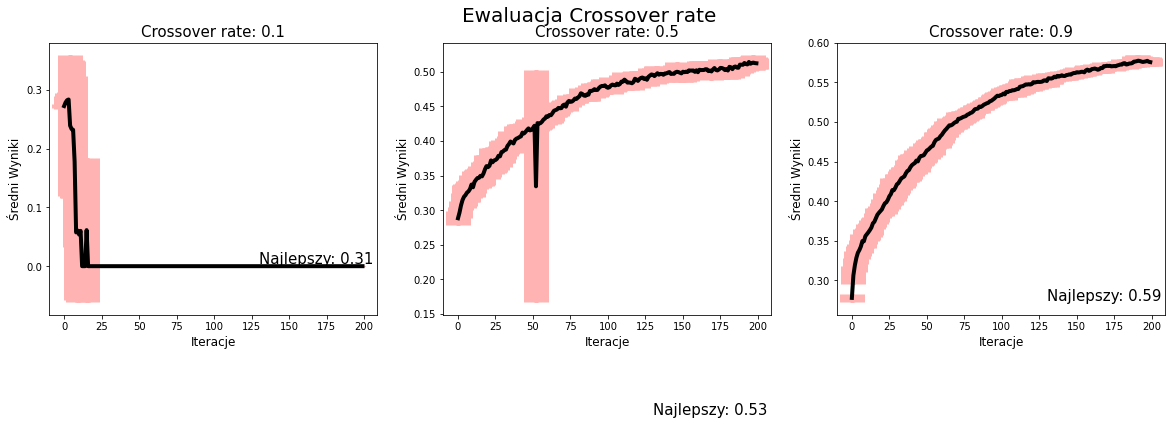

In [10]:
params = {"Crossover rate": [0.1, 0.5, 0.9]}
genetic_algorithm = GeneticAlgorithm(*parameters)
measured_param_history = genetic_algorithm.test_param(
    test_cases=TEST_CASES, params=params, iterations=ITERATIONS, task=generated_task
)
plot_tests_history(measured_param_history, params)

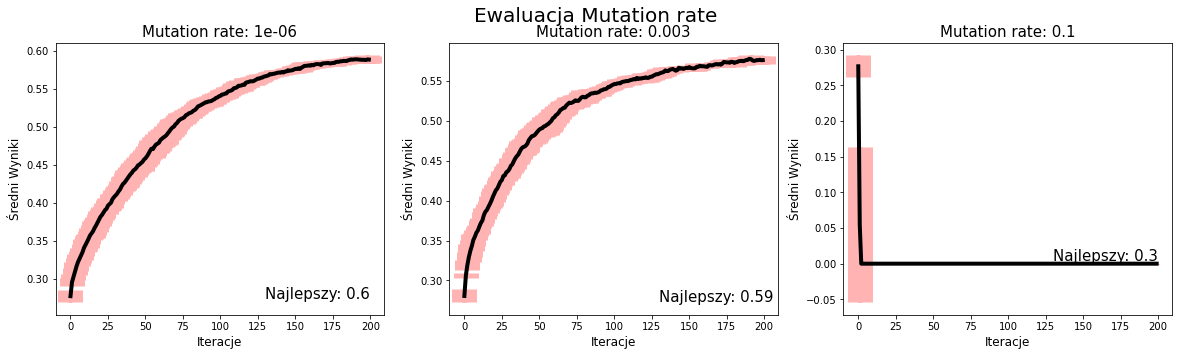

In [9]:
params = {"Mutation rate": [0.000001,0.003,0.1]}
genetic_algorithm = GeneticAlgorithm(*parameters)
measured_param_history = genetic_algorithm.test_param(test_cases=TEST_CASES, params=params ,iterations=ITERATIONS, task=generated_task)
plot_tests_history(measured_param_history, params)

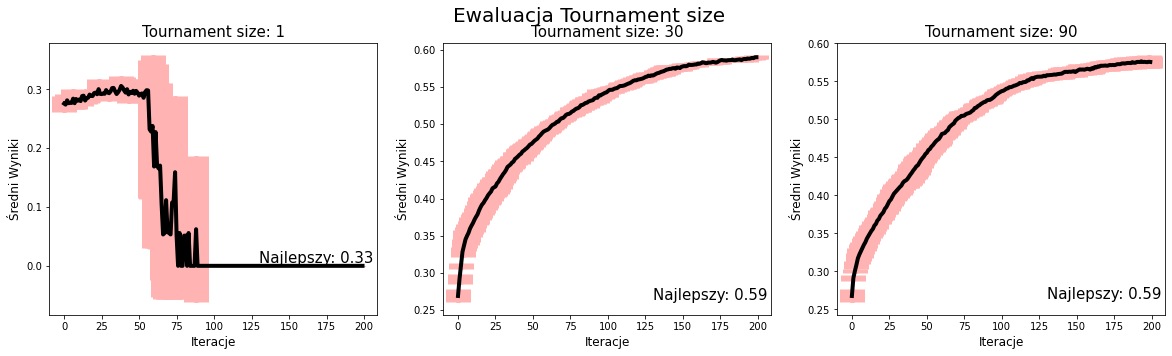

In [12]:
params = {"Tournament size": (np.array([0.01,0.3,0.9])*POPULATIONS_SIZE).astype(np.int32)}
genetic_algorithm = GeneticAlgorithm(*parameters)
measured_param_history = genetic_algorithm.test_param(test_cases=TEST_CASES, params=params ,iterations=ITERATIONS, task=generated_task)
plot_tests_history(measured_param_history, params)

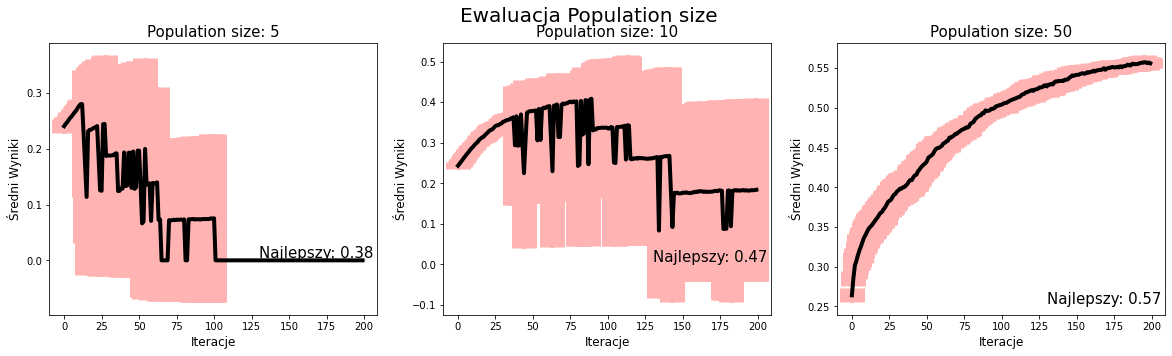

In [11]:
params = {"Population size": [5,10,50]}
genetic_algorithm = GeneticAlgorithm(*parameters)
measured_param_history = genetic_algorithm.test_param(test_cases=TEST_CASES, params=params ,iterations=ITERATIONS, task=generated_task)
plot_tests_history(measured_param_history, params)

In [31]:
POPULATIONS_SIZE = 100 # na 100
TOURNAMENT_SIZE = 50
CROSSOVER_RATE = 0.90
MUTATION_RATE = 0.001
ITERATIONS = 500 # na 200
TEST_CASES = 5
parameters = (POPULATIONS_SIZE, TOURNAMENT_SIZE, CROSSOVER_RATE, MUTATION_RATE) 
genetic_algorithm = GeneticAlgorithm(*parameters)
the_best_individual, best_history, best_genome_history, mean_evalueation_history = genetic_algorithm.fit(iterations=ITERATIONS, task=generated_task)

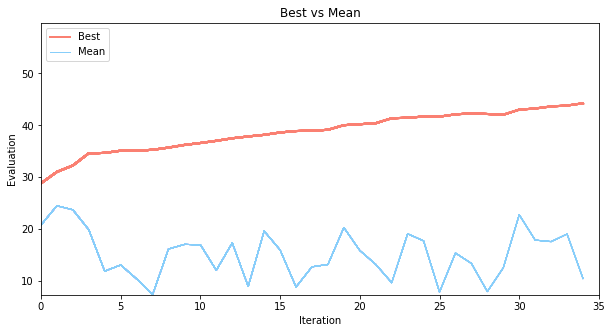

In [32]:
from matplotlib.animation import FuncAnimation
from matplotlib.legend_handler import HandlerLine2D

plt.style.use("seaborn-pastel")
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)


def init():
    ax.set(
        xlim=(0, 35),
        ylim=[min(mean_evalueation_history)/1000, max(best_history)/1000],
        title="Best vs Mean",
        xlabel="Iteration",
        ylabel="Evaluation",
    )


def update(i):
    if i >= 35:
        i = 35
    l1 = plt.plot(np.array(best_history[:i])/1000, linewidth=2, color="salmon")
    l2 = plt.plot(np.array(mean_evalueation_history[:i])/1000, linewidth=1, color="lightskyblue")
    plt.legend(["Best", "Mean"], loc="upper left")


anim = FuncAnimation(fig, update, frames=50, init_func=init, interval=1)
anim.save("animation.gif", writer="imagemagick")
plt.show()

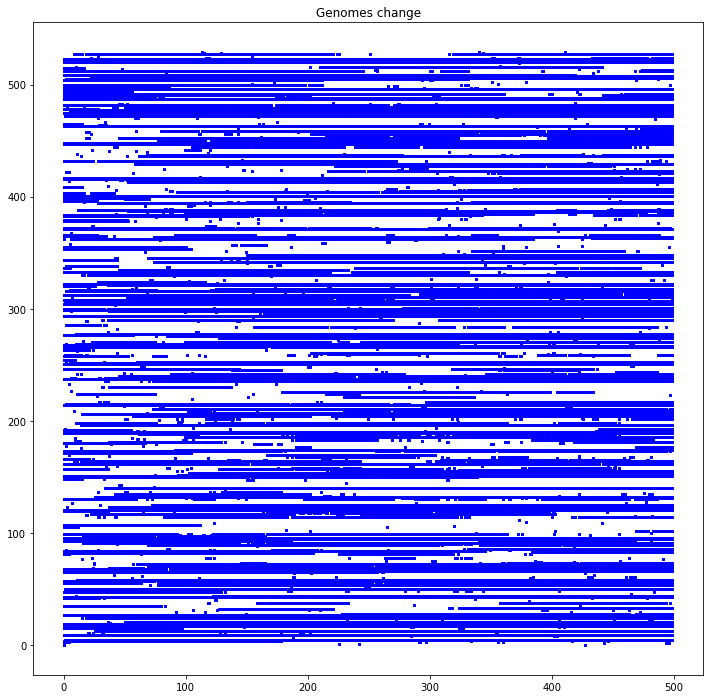

In [24]:
data = np.array(best_genome_history)
fig, ax = plt.subplots()

fig.set_size_inches(12,12)
for col_no in range(data.shape[1]):
    col = data[:, col_no].copy()
    x = col*range(col.shape[0])
    col *= col_no
    x, col
    plt.title("Genomes change")
#     plt.axis('off')
    plt.scatter(x, col, marker=',', c='b', s=3)